## Math 118 Extra Credit

### Multinomial Logistic Regression

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
import math

Goal: predict disease class from the data. \
We will be using multinomial logistic regression.
Dataset can be found at: https://archive.ics.uci.edu/ml/datasets/dermatology

In [2]:
# Pre-processing
# dermatology.csv can be found in the GitHub
derm_data = pd.read_csv("dermatology.csv", delimiter = ',')
derm_data.head()

,2,2.1,0,3,0.1,0.2,0.3,0.4,1,0.5,...,0.19,0.20,3.2,0.21,0.22,0.23,1.1,0.24,55,2.3
0,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,41,2


In [3]:
# We change the column names to make the data interpretable.
colnames = ['erythema', 'scaling', 'definite borders', 
            'itching', 'koeber phenomenon', 'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
            'knee and elbow invovlement', 'scalp involvement', 'family history', 'mealnin incontinence', 
            'eosinophils in the infiltrate', 'PNL infiltrate', 'fibrosis of the papillary dermis', 
            'exocytosis', 'acanthosis', 'hyperkeratosis', 'parakeratosis', 'dlubbing of the rete ridges', 
            'elongation of rete ridges', 'thinning of the suprapapillary epidermis', 'spongifrom pustule', 'munor microabcess', 'focal hypergranulosis',
           'disappearnce of the granular layer', 'vaculoisation and damage of basil layer', 'spongiosis', 'saw-tooth appearnce of retes', 'follicular horn plug',
           'perifollicular parakeratosis', 'inflammatory monoluclear infiltrate', 'band-like infiltrate', 'Age(linear)', 'Classcode']

In [4]:
derm_data.columns = colnames

In [5]:
# Remove all NA's from data
for k in range(derm_data.shape[0]):
    for i in range(derm_data.shape[1]):
        if (derm_data.iloc[k,i] == '?'):
            derm_data.iloc[k,i] = 'nan'
derm_data[['Age(linear)']].fillna(value=derm_data[['Age(linear)']].mean(),inplace=True)

/var/folders/65/v5r0sb7x0sx44yw1wmchmv6c0000gn/T/ipykernel_6625/362132942.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  derm_data[['Age(linear)']].fillna(value=derm_data[['Age(linear)']].mean(),inplace=True)


In [6]:
derm_data.head()

,erythema,scaling,definite borders,itching,koeber phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow invovlement,scalp involvement,...,disappearnce of the granular layer,vaculoisation and damage of basil layer,spongiosis,saw-tooth appearnce of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,Age(linear),Classcode
0,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,41,2


Since logistic regression tries to find a linear boundary between classes in our data, we will first try to visualize our data.

In [7]:
derm_data.describe()

,erythema,scaling,definite borders,itching,koeber phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow invovlement,scalp involvement,...,focal hypergranulosis,disappearnce of the granular layer,vaculoisation and damage of basil layer,spongiosis,saw-tooth appearnce of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,Classcode
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2.068493,1.794521,1.553425,1.361644,0.635616,0.449315,0.167123,0.378082,0.613699,0.520548,...,0.394521,0.465753,0.457534,0.947945,0.454795,0.104110,0.115068,1.868493,0.556164,2.805479
std,0.665656,0.702408,0.905126,1.136632,0.908653,0.958353,0.571304,0.835057,0.984120,0.906472,...,0.850322,0.865743,0.955884,1.126615,0.955758,0.451018,0.489357,0.725682,1.107044,1.599441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,6.000000


/var/folders/65/v5r0sb7x0sx44yw1wmchmv6c0000gn/T/ipykernel_6625/83350575.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(derm_data.corr())


<AxesSubplot:>

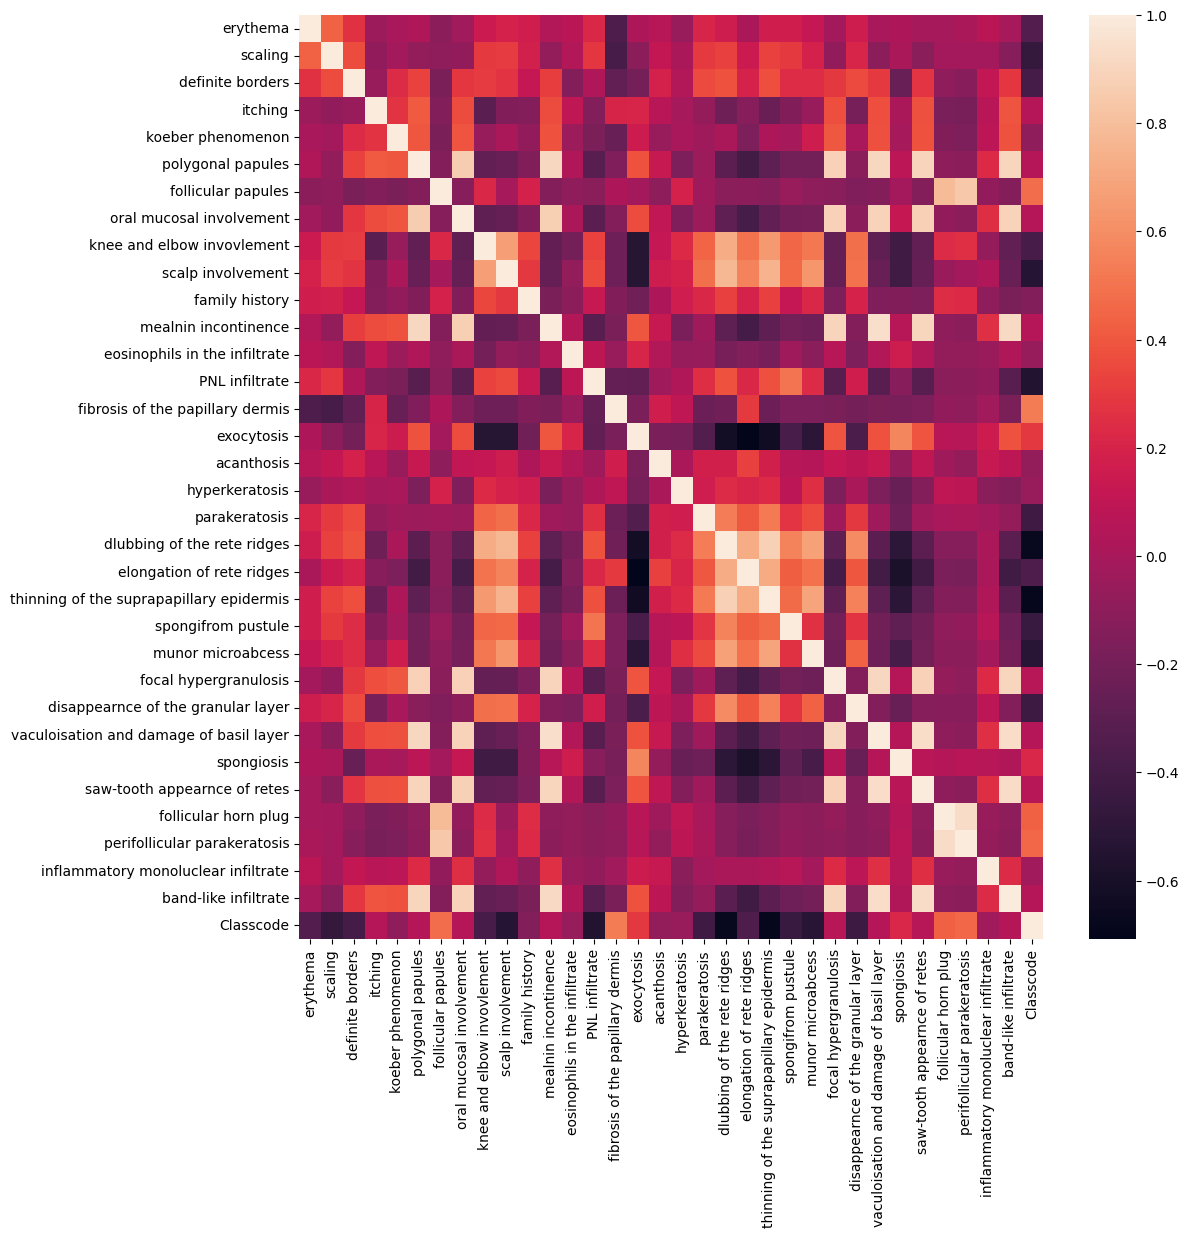

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(derm_data.corr())

When we draw a histogram of the spread of the "Classcode" column, we see that there is a much higher frequency of Class 1 Disease (psoriasis) than any other disease.

Text(0.5, 1.0, 'Histogram of Classcodes (Disease Frequency)')

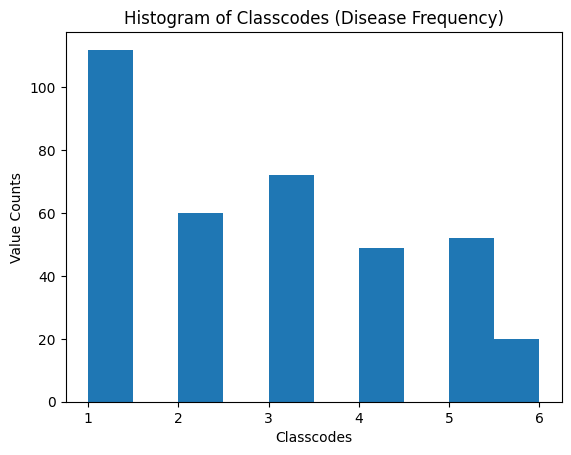

In [9]:
# Visualization - lots of cases of class 1 disease (psoriasis)
plt.hist(derm_data[['Classcode']])
plt.xlabel('Classcodes')
plt.ylabel('Value Counts')
plt.title('Histogram of Classcodes (Disease Frequency)')

We split our dataset into our features (34 features) and our target (1 target).

In [10]:
features = derm_data[['erythema', 'scaling', 'definite borders', 
            'itching', 'koeber phenomenon', 'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
            'knee and elbow invovlement', 'scalp involvement', 'family history', 'mealnin incontinence', 
            'eosinophils in the infiltrate', 'PNL infiltrate', 'fibrosis of the papillary dermis', 
            'exocytosis', 'acanthosis', 'hyperkeratosis', 'parakeratosis', 'dlubbing of the rete ridges', 
            'elongation of rete ridges', 'thinning of the suprapapillary epidermis', 'spongifrom pustule', 'munor microabcess', 'focal hypergranulosis',
           'disappearnce of the granular layer', 'vaculoisation and damage of basil layer', 'spongiosis', 'saw-tooth appearnce of retes', 'follicular horn plug',
           'perifollicular parakeratosis', 'inflammatory monoluclear infiltrate', 'band-like infiltrate', 'Age(linear)']]
features = features.to_numpy()
target = derm_data[['Classcode']]
target = target.to_numpy()
target = np.squeeze(target)

In [11]:
features.shape, target.shape

((365, 34), (365,))

Now we standardize the data to ensure that our data has a standard deviation of 1.

In [12]:
scaler = StandardScaler().fit(features)
features = scaler.transform(features)

In [13]:
# Successfully standardized the features
for i in range(features.shape[1]):
    print(np.std(features[:,i]))

1.0
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999999
1.0
0.9999999999999998
1.0
1.0
0.9999999999999997
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
0.9999999999999998
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
nan


Now we define our logit function that will take in our features, and our randomly initialized $w_0$ (weight parameter) and $b_0$ (bias parameter) and calculate a logit score for each feature. As a reminder, a logit function (log-odds function) calculates the probability of a certain event occurring in the domain of [0,1]. It is the inverse of the logistic sigmoid function, which predicts probabilities in the range of [0,1].

In [14]:
def logitscores(features, w_0, b_0):
    logitvalues = np.zeros(shape=(features.shape[0],6))
    for i in range(len(logitvalues)):
        # For every row in the features dataframe, take the dot product with the weights and add the bias
        # w^Tx + b => hyperplane
        logit = np.squeeze(np.dot(w_0, features[i]) + np.transpose(b_0))
        logitvalues[i,:] = logit
    return logitvalues

Now we define a softmax function. In multinomial logistic regression, we use a softmax function, which calculates the probabilities of K possible outcomes for a vector of K numbers. This is a generalization of the sigmoid function used in binary logistic regression. The softmax function is:

$$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$

In [15]:
def softmax(logitvalues, axis=-1):
    K_prob = np.zeros(logitvalues.shape)
    # We us kw to scale the softmax values to be between 0 and 1
    kw = dict(axis=axis, keepdims = True)
    logitvalues = logitvalues - logitvalues.max(**kw)
    for i in range(logitvalues.shape[0]):
        # Use the definition of the softmax function
        a = np.exp(logitvalues[i])
        b = a/a.sum(**kw)
        K_prob[i] = b
    return K_prob

Now we define our Logisitc Regression function. We calculate the logit scores, the probability matrix (the probability of each data point (person) being classified in each class (from 1-6), and classify each data point (person) into the class with the highest probability.

In [16]:
def TrainingLogisticRegression(X_train, w_0, b_0):
    logits = logitscores(X_train, w_0, b_0)
    K_prob = softmax(logits)
    K_prob = np.nan_to_num(K_prob,10**-10)
    predict = np.zeros(shape=X_train.shape[0])
    for i in range(K_prob.shape[0]):
        predict[i] = np.argmax(K_prob[i])
    return K_prob, predict

We initialize random weights and biases to test our functions.

In [17]:
w_0 = np.random.randn(6, 34)
b_0 = np.random.randn(6,1)

In [18]:
K_prob, predict = TrainingLogisticRegression(features, w_0, b_0)
print(K_prob.shape)
print(predict.shape)

(365, 6)
(365,)


In [19]:
def model_accuracy(predict, target):
    return 100.0 * np.sum(predict == target)/len(target)

In [20]:
model_accuracy(predict, target)

21.91780821917808

The model accuracy is pretty low since this it is generic, so we will improve our model by optimizing hyperparameters.

### Optimizing our model

We split our data into training and testing data.

In [21]:
# running train_test_split for our dataset
train_features, test_features, train_target, test_target = train_test_split(features,target,test_size = 0.2)

In [22]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((292, 34), (73, 34), (292,), (73,))

We scale the data to ensure a standard deviation of 1

In [23]:
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
scaler = StandardScaler().fit(test_features)
test_features = scaler.transform(test_features)

In [24]:
for i in range(train_features.shape[1]):
    print(np.std(train_features[:,i]))
for i in range(test_features.shape[1]):
    print(np.std(test_features[:,i]))

0.9999999999999983
0.9999999999999999
0.9999999999999982
1.0000000000000009
0.9999999999999988
0.9999999999999993
0.9999999999999993
1.0000000000000016
1.0000000000000004
1.0
0.9999999999999982
1.0
1.000000000000002
1.0000000000000004
0.9999999999999978
1.0
1.0000000000000013
0.9999999999999997
1.0000000000000016
1.0000000000000016
1.0000000000000004
0.9999999999999988
0.9999999999999982
1.000000000000001
1.0000000000000016
0.9999999999999986
0.9999999999999978
1.0
0.9999999999999991
1.000000000000004
0.9999999999999972
1.000000000000002
0.9999999999999998
nan
0.9999999999999999
1.0
1.0000000000000004
1.0
1.0
1.0000000000000004
0.9999999999999993
1.0000000000000004
0.9999999999999994
1.0000000000000007
0.9999999999999994
0.9999999999999996
1.0000000000000004
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000004
0.9999999999999999
0.9999999999999999
1.0000000000000004
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999993

In multinomial logistic regression, maximizing the likelihood of the parameters is equivalent to minimizing the cross-entropy loss. We will define our cross-entropy loss function that we will later minimize using an algorithm. 

As a reminder, cross-entropy loss is defined as:

$$J(\theta) = -[\sum_{i=1}^m y^{(i)} \log h_{\theta} (x^{(i)}) + (1-y^{(i)} \log (1- h_{\theta}(x^{(i)}))]$$

where $(x^{(i)}, y^{(i)})$ correspond to a data point from our training set and $h_{\theta}$ is the probability of our parameter set being equal to $\theta$.

In [25]:
def CELoss(K_prob, target):
    target = target-1
    total_loss = 0
    for i in target:
        total_loss += -np.log(K_prob[i])
    avg_loss = total_loss/K_prob.shape[0]
    return np.average(avg_loss)

We use Stochastic Gradient Descent to minimize our cross-entropy loss. We calculate the probability matrix (the probability of each data point (person) being classified in each class (from 1-6)) and the prediction vector (the predicted class of each data point (person) based on the highest probability). We then find the gradient of our $w_0$ weight vector and $b_0$ bias vector and implement the algorithm:

$$w_{k+1} = w_k - (\alpha * \nabla(f(w_k)))$$
$$b_{k+1} = b_k - (\alpha * \nabla(f(b_k)))$$

for $i = 1,...,\text{K_max}$ where $\text{K_max}$ is the maximum number of iterations.

In [26]:
def SGD(alpha, K_max, target, features, w_0, b_0):

    loss_function = np.zeros(features.shape[0])
 
    for i in range(K_max):
        prob,predict = TrainingLogisticRegression(features, w_0, b_0)
        loss_function[i] = CELoss(prob, target)
        prob[np.arange(features.shape[0]),target] -= 1
        
        grad_weight = np.dot(prob.T,features)
        grad_biases = np.matrix(np.sum(prob, axis = 0)).T
        
        w_0 -= (alpha * grad_weight)
        b_0 -= (alpha * grad_biases)
        
    return w_0,b_0,loss_function

We initialize random $w_0$ and $b_0$ and run our SGD algorithm.

In [27]:
w_0 = np.random.randn(6, 34)
b_0 = np.random.randn(6,1)

In [28]:
w_star, b_star, loss_function = SGD(0.1, 10, train_target-1, train_features, w_0, b_0)

/var/folders/65/v5r0sb7x0sx44yw1wmchmv6c0000gn/T/ipykernel_6625/3864495697.py:5: RuntimeWarning: divide by zero encountered in log
  total_loss += -np.log(K_prob[i])


In [29]:
w_star = np.nan_to_num(w_star,0)

In [30]:
test_prob, test_pred = TrainingLogisticRegression(test_features, w_star, b_star)
test_pred = test_pred + 1

model_accuracy(test_pred, test_target)

93.15068493150685

---------

We can compare the accuracy of our model with the built-in LogisticRegression function in sklearn.

In [31]:
train_features = train_features.astype('float')
test_features = test_features.astype('float')

In [32]:
train_features = np.nan_to_num(train_features,0)
test_features = np.nan_to_num(test_features,0)

We use the LogisticRegression function in sklearn, with argument multiclass = 'multinomial'.

In [33]:
model = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
model.fit(train_features, train_target)
class_pred = model.predict(train_features)
score = model.score(test_features, np.squeeze(test_target))
print(score)

0.9452054794520548


The sklearn accuracy score is very similar to our accuracy score.

We also do 5-fold cross validation and take the average to find the average model accuracy of our five repetitions.

In [34]:
cross_val = LogisticRegression(solver='newton-cg', multi_class='multinomial')
scores = cross_val_score(cross_val, train_features, train_target, cv=5)
scores

array([0.94915254, 0.98305085, 0.98275862, 0.96551724, 0.94827586])

In [35]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.03)


The accuracy is very high, similar to our model.

This was an implementation of multinomial logistic regression on a dataset to classify people into six different disease classes based on 34 features using the publicly available dataset from https://archive.ics.uci.edu/ml/datasets/dermatology.